<a href="https://www.kaggle.com/code/matthewjansen/nlp-medical-abstract-segmentation?scriptVersionId=135504348" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id=toc></a>

<center><h1>📄 NLP | Medical Abstract Segmentation with PubMed-RCT20k</h1></center>
<div style='border-width: 2px;
              border-bottom-width:4px;
              border-bottom-color:#30A2FF;
              border-bottom-style: solid;'></div>
<br>

<center>
    <img src="https://i.postimg.cc/BZmFrknh/Medical-Abstract-Segmentation.png" 
         alt ="Medical-Abstract-Segmentation" 
         style='width: 600px;'>
    <figcaption>
            Image by <a href='https://www.kaggle.com/matthewjansen'>Author</a>
    </figcaption>
</center>


## 🎯 Objective
Abstracts from medical research papers can be somewhat difficult to read at a glance as they contain complex wording, densely represented in a single paragraph. What if there was a way to segment these abstracts so that they become optimized for speed reading (skimmable)?

The purpose of this notebook is to explore building an Natural Language Processing (NLP) model with TensorFlow to segment text lines of abstracts from medical research papers in order to improve the readability of these said abstracts while maintaining a compute efficiency & implementation complexity constraint (CPU-only and simple implementation).

The dataset used to train the NLP model is based of a paper titled **"PubMed 20k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts"**, published in October 2017. 

The NLP model architecture used in this notebook is inspired by this paper titled **"Neural Networks for Joint Sentence Classification in Medical Paper Abstracts"** (also mentioned in the dataset paper), published in December 2016. Note that the model implemented in this notebook aims to reproduce similar results as seen in the aforementioned paper.

> - *Dataset paper*: [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071)
> - *Model architecture paper*: [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/abs/1612.05251)

<hr>

## Table of contents
- [1 | Downloading The Dataset](#1)
   > - [Downloading From GitHub](#1.1)
   > - [Using the Kaggle version of the dataset](#1.2)

- [2 | Explore & Preprocess Raw Data](#2)
   > - [Explore & Preprocess Data](#2.1)
   > - [Tranform preprocessed data into pandas dataframe](#2.2)
   > - [Inspect Labels Data Distribution](#2.3)
   
- [3 | Prepare Data For Training & Testing](#3)
   > - [Get Sentences As Lists](#3.1)
   > - [One-Hot Encode Targets](#3.2)
   > - [Label Encode Targets](#3.3)
   > - [One-Hot Encode `current_lines`](#3.4)
   > - [Apply Smoothing to `current_lines` encodings](#3.5)
   
- [4 | Construct Dataset Input Pipeline](#4)

- [5 | Construct Model Architecture](#5)
   > - [Encode Text with Universal Sentence Encoder](#5.1)
   > - [Define Model Constructor](#5.2)
   > - [Build model using TensorFlow's Functional API](#5.3)

- [6 | Train Model](#6)
   > - [Define Callbacks and Metrics for Model Training](#6.1)
   > - [Compile & Train Model](#6.2)
   
- [7 | Model Performance Inspection](#7)
   > - [Generate Validation Probabilities & Predictions](#7.1)
   > - [Generate Test Probabilities & Predictions](#7.2)
   > - [Plot Model History](#7.3)
   > - [Inspect Model Performance Via Classification Metrics](#7.4)
   > - [Inspect Validation Performance](#7.5)
   > - [Inspect Test Performance](#7.6)
   > - [Plot Confusion Matrix](#7.7)
   > - [Inspect Predicted Test Labels](#7.8)
   > - [Inspect Least Accurate Predictions](#7.9)
   > - [Inspect Most Inaccurate Predictions](#7.10)
   
- [8 | Predict On Sample From The Wild](#8)
   > - [Preprocess the Wild Abstract](#8.1)
   > - [Generate Probabilities](#8.2)
   > - [View Wild Abstract Predictions](#8.3)
   > - [View the segmented abstract in color](#8.4)
   
- [9 | Discussion Regarding Model Performance](#9)

- [Conclusion](#conclusion)

<hr>

<center>
    <div class="alert alert-block" style='color:#000000;
           padding: 10px 10px 10px 10px;
           border-radius:10px;
           background-color:#00C4FF;
           font-size:100%;'>  
        <h3 style='color:#000000;'><b>Thank you for taking the time to view this notebook!</b></h3>
    </div>
</center>

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import OneHotEncoder, LabelEncoder 
from sklearn.metrics import (
    accuracy_score, top_k_accuracy_score, f1_score, matthews_corrcoef, 
    classification_report, precision_recall_fscore_support, 
    confusion_matrix, ConfusionMatrixDisplay
)

<a id=1></a>
# 1 | Downloading The Dataset
<div style='border-width: 2px;
              border-bottom-width:4px;
              border-bottom-color:#30A2FF;
              border-bottom-style: solid;'></div>
<br>

The dataset is available on GitHub, see the link attached below to access the dataset.

GitHub Source: https://github.com/Franck-Dernoncourt/pubmed-rct

<a id=1.1></a>
### Downloading From GitHub
If you wish to download the dataset from GitHub, uncomment and run the code cells below.

In [2]:
# Clone the dataset directory
#!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

In [3]:
# Inspect the PubMed_20K dataset directory
#!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

<a id=1.2></a>
### Using the Kaggle version of the dataset
I have upload the dataset here on Kaggle to make it more accessible for usage in notebooks. Comment out the code cells from section above if you wish to use the kaggle version of the dataset. 

Here's the link to the Kaggle dataset: [PubMed 200k RCT](https://kaggle.com/datasets/666f37e9e9a1c3d1e6c4b9882dd23c25c722c58b490e20fd65adcd611688ef80)

In [4]:
!ls /kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.csv  dev.txt  test.csv  test.txt  train.csv  train.txt


In [5]:
# For this model we'll use the 20k dataset no preprocessing
dataset_dir = "/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT/"

<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#B6EADA;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id=2></a>
# 2 | Explore & Preprocess Data
<div style='border-width: 2px;
              border-bottom-width:4px;
              border-bottom-color:#30A2FF;
              border-bottom-style: solid;'></div>
<br>

As we'll see, the data has not been processed into a more consumable format such as a .csv file format. Thus, we'll have to explore the raw data to understand how the creators have stored the data before we can preprocess the dataset into a consumable format such as a Pandas DataFrame. 

In [6]:
def get_raw_data(filepath):
    with open(filepath) as f:
        return f.readlines()

In [7]:
# Load the data
train_data = get_raw_data(dataset_dir + 'train.txt')

In [8]:
# View the first 20 lines from the dataset text file
train_data[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( 0-100 mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .\n',
 'METHODS\tSerum levels of interleukin 1 ( IL-1 ) , IL-6 , tumor necrosis factor ( TNF )

<a id=2.1></a>
### Preprocess raw data for classification

We see that each abstract is seperated by a newline ('\n'). 
We also see that each abstract starts with '###', followed by the abstract id and a newline. 
Each line from an abstract starts with the target which we want to predict, followed by the abstract line text.

**In summary, this is the outline of an abstract:**
> - *Abstract Start* -> ###< abstract_id >\n
> - *Abstract Line* -> < TARGET >\t< abstract_text >
> - *Abstract End* -> \n

Now all we need to do is extract this information into a Pandas DataFrame.

In [9]:
def preprocess_raw_data(filepath):
    raw_data = get_raw_data(filepath)
    abstract_data = ''
    abstract_samples = []
    abstract_id = 0

    for line in raw_data:
        if line.startswith('###'): # check if current line is an abstract start (line -> ###[abstract_id]\n)
            abstract_id = int(line.replace('###', '').replace('\n', '')) # get abstract id
            abstract_data = ''

        elif line.isspace(): # check if current line is an abstract end (line -> '\n')
            abstract_data_split = abstract_data.splitlines()
            
            for abstract_line_number, abstract_line in enumerate(abstract_data_split):
                line_data = {} # store lines in dictionary
                target_text_split = abstract_line.split("\t") # split target label from text 
                
                line_data["abstract_id"] = abstract_id # get abstract id
                line_data["line_id"] = f'{abstract_id}_{abstract_line_number}_{len(abstract_data_split)}' # create id for each line
                line_data["abstract_text"] = target_text_split[1] # get target text and lower it
                line_data["line_number"] = abstract_line_number # get line number in the abstract
                line_data["total_lines"] = len(abstract_data_split) # get total count for abstract lines (counter starts at 1)
                line_data['current_line'] = f'{abstract_line_number}_{len(abstract_data_split)}' # embed line_number & total_lines into one feature 
                line_data["target"] = target_text_split[0] # get target label
                
                abstract_samples.append(line_data) # append line data to abstract samples list

        else: # if the above conditions aren't fulfilled, the line is a abstract text line (line -> [TARGET]\t[abstract_text])
            abstract_data += line

    return abstract_samples

In [10]:
%%time
# Get train data from file and preprocess it
train_samples = preprocess_raw_data(dataset_dir + "train.txt")

CPU times: user 704 ms, sys: 158 ms, total: 861 ms
Wall time: 862 ms


In [11]:
%%time
# Get dev/validation data from file and preprocess it
val_samples = preprocess_raw_data(dataset_dir + "dev.txt")

CPU times: user 123 ms, sys: 16.3 ms, total: 139 ms
Wall time: 195 ms


In [12]:
%%time
# Get test data from file and preprocess it
test_samples = preprocess_raw_data(dataset_dir + "test.txt")

CPU times: user 120 ms, sys: 26 ms, total: 146 ms
Wall time: 193 ms


In [13]:
train_count = len(train_samples)
val_count = len(val_samples)
test_count = len(test_samples)
total = train_count + val_count + test_count

In [14]:
print(f'train samples count:\t\t{train_count}')
print(f'dev/validation samples count:\t{val_count}')
print(f'test samples count:\t\t{test_count}')

print(f'\ntotal samples:\t\t\t{total}')

train samples count:		180040
dev/validation samples count:	30212
test samples count:		30135

total samples:			240387


In [15]:
# View first 10 abstracts from the train set
train_samples[:10]

[{'abstract_id': 24293578,
  'line_id': '24293578_0_12',
  'abstract_text': 'To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_lines': 12,
  'current_line': '0_12',
  'target': 'OBJECTIVE'},
 {'abstract_id': 24293578,
  'line_id': '24293578_1_12',
  'abstract_text': 'A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
  'line_number': 1,
  'total_lines': 12,
  'current_line': '1_12',
  'target': 'METHODS'},
 {'abstract_id': 24293578,
  'line_id': '24293578_2_12',
  'abstract_text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 12,

<a id=2.2></a>
## Tranform preprocessed data into pandas dataframe

Now that we have seperated each line into dictionaries we can transform the datasets into a pandas DataFrames.

In [16]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [17]:
# View the first 20 samples in train_df
train_df.head(20)

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,24293578,24293578_0_12,To investigate the efficacy of 6 weeks of dail...,0,12,0_12,OBJECTIVE
1,24293578,24293578_1_12,A total of 125 patients with primary knee OA w...,1,12,1_12,METHODS
2,24293578,24293578_2_12,Outcome measures included pain reduction and i...,2,12,2_12,METHODS
3,24293578,24293578_3_12,Pain was assessed using the visual analog pain...,3,12,3_12,METHODS
4,24293578,24293578_4_12,Secondary outcome measures included the Wester...,4,12,4_12,METHODS
5,24293578,24293578_5_12,"Serum levels of interleukin 1 ( IL-1 ) , IL-6 ...",5,12,5_12,METHODS
6,24293578,24293578_6_12,There was a clinically relevant reduction in t...,6,12,6_12,RESULTS
7,24293578,24293578_7_12,The mean difference between treatment arms ( 9...,7,12,7_12,RESULTS
8,24293578,24293578_8_12,"Further , there was a clinically relevant redu...",8,12,8_12,RESULTS
9,24293578,24293578_9_12,These differences remained significant at 12 w...,9,12,9_12,RESULTS


<a id=2.3></a>
### Inspect Train Data Distribution

In [18]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

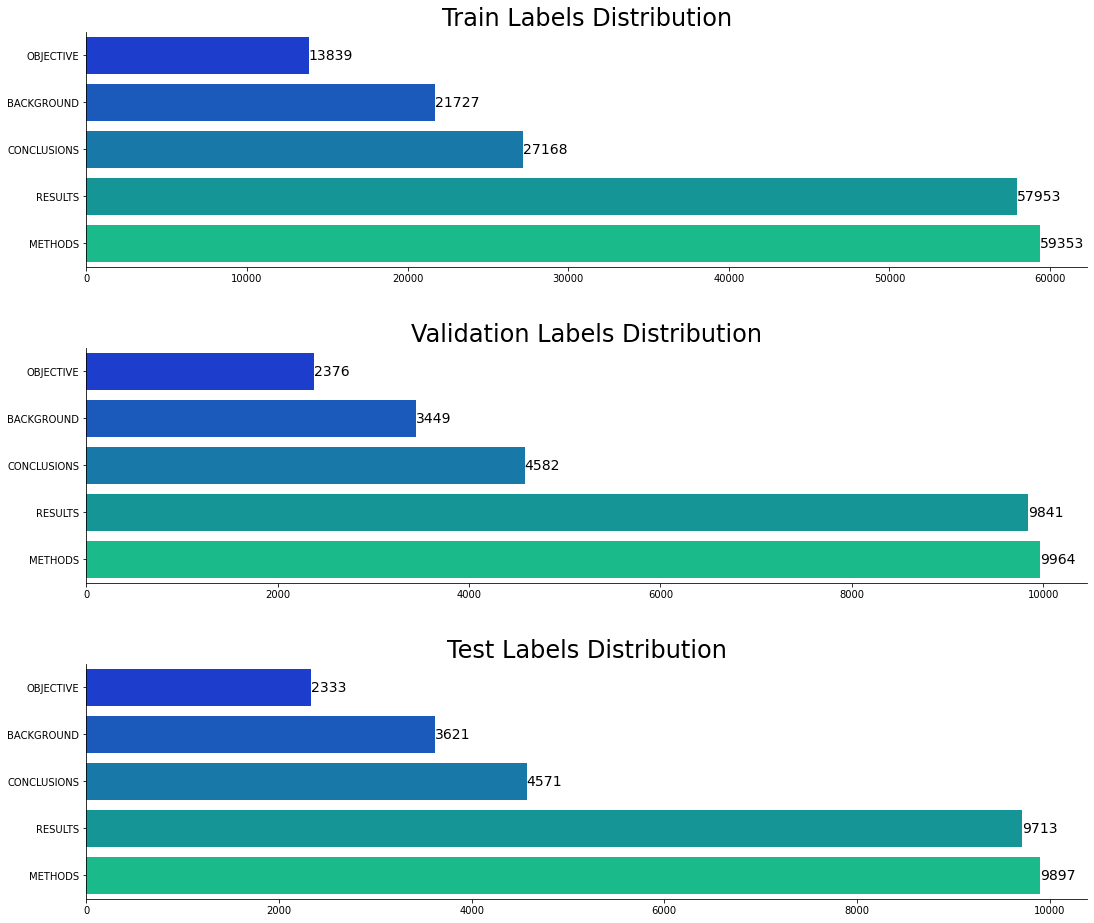

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 14))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)
sns.despine();
# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=24)
train_distribution = train_df['target'].value_counts().sort_values()
bar_plot = sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient="h", palette=sns.color_palette("winter", 5),
            ax=ax1);

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);
    
# Plot Validation Labels Distribution
ax2.set_title('Validation Labels Distribution', fontsize=24)
val_distribution = val_df['target'].value_counts().sort_values()
bar_plot = sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            orient="h", palette=sns.color_palette("winter", 5),
            ax=ax2);
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);
    
# Plot Test Labels Distribution
ax3.set_title('Test Labels Distribution', fontsize=24)
test_distribution = test_df['target'].value_counts().sort_values()
bar_plot = sns.barplot(
    x=test_distribution.values,
    y=list(test_distribution.keys()),
    orient="h", palette=sns.color_palette("winter", 5),
    ax=ax3);

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);


<div class="alert alert-block alert-info">
<h3>Observation</h3>
The dataset is imbalanced (number of samples per class are not roughly the same). This is generally a problem when training a model as this generally introduces overfitting or underfitting for the imbalanced classes.
<br>
Methods to deal with this issue is to use upsampling or downsampling techniques like SMOTE or randomly removing samples of the oversampled classes or just to get more data for the undersampled classes. However, we will not implement such techniques in order to avoid introducing more feature dependencies.
</div>

<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#B6EADA;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id=3></a>
# 3 | Prepare Data For Training & Testing
<div style='border-width: 2px;
              border-bottom-width:4px;
              border-bottom-color:#30A2FF;
              border-bottom-style: solid;'></div>
<br>

Now that we have the data in a consumable format, we need to process the data in order to generate a data input pipeline for training a model.

<a id=3.1></a>
### Get Sentences As Lists

In [20]:
# Convert abstract text lines into lists
train_sentences = train_df["abstract_text"].tolist()
val_sentences = val_df["abstract_text"].tolist()
test_sentences = test_df["abstract_text"].tolist()

In [21]:
train_sentences_count = len(train_sentences)
val_sentences_count = len(val_sentences)
test_sentences_count = len(test_sentences)
total_sentences_count = train_sentences_count + val_sentences_count + test_sentences_count

print(f'Train samples count:\t\t{train_sentences_count}')
print(f'Dev/Validation sample count:\t{val_sentences_count}')
print(f'Test sample count:\t\t{test_sentences_count}')
print(f'Total samples:\t\t\t{total_sentences_count}')

Train samples count:		180040
Dev/Validation sample count:	30212
Test sample count:		30135
Total samples:			240387


In [22]:
# View first 5 lines of train sentences
train_sentences[:5]

['To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( 0-100 mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .']

<a id=3.2></a>
### One-Hot Encode Targets

In [23]:
one_hot_encoder = OneHotEncoder(sparse=False)

In [24]:
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [25]:
train_df["target"][0]

'OBJECTIVE'

In [26]:
# inspect one hot encoded targets
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

<a id=3.3></a>
### Label Encode Targets

In [27]:
label_encoder = LabelEncoder()

In [28]:
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# inspect label encoded targets
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [29]:
# Get class names and number of classes from label_encoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(f'Number of classes: {num_classes}')
print(f'Classes: {class_names}')

Number of classes: 5
Classes: ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


<a id=3.4></a>
### One-Hot Encode `current_lines`

In [30]:
line_one_hot_encoder = OneHotEncoder(sparse=False)

In [31]:
%%time
train_lines_encoded = line_one_hot_encoder.fit_transform(train_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)
val_lines_encoded = line_one_hot_encoder.transform(val_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)
test_lines_encoded = line_one_hot_encoder.transform(test_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)

CPU times: user 542 ms, sys: 1.17 s, total: 1.71 s
Wall time: 1.72 s


In [32]:
test_lines_encoded.shape

(30135, 460)

<a id=3.5></a>
### Apply Smoothing to `current_lines` encodings

In [33]:
def apply_smoothing(line_one_hot, esp=0.01):
    return np.abs(line_one_hot - esp)

def revert_smoothing(line_one_hot_smooth, esp=0.01):
    unsmooth = line_one_hot_smooth
    
    unsmooth[unsmooth>esp] = 1.0
    unsmooth[unsmooth<=esp] = 0.0
    
    return unsmooth

In [34]:
# Only apply smoothing to train lines feature 
train_lines_encoded = apply_smoothing(train_lines_encoded)

<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#B6EADA;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id=4></a>
# 4 | Construct Dataset Input Pipeline
<div style='border-width: 2px;
              border-bottom-width:4px;
              border-bottom-color:#30A2FF;
              border-bottom-style: solid;'></div>
<br>

In order to train the model we'll build an input data pipeline using TensorFlow's tf.data API to handle the loading and passing of the preprocessed data to the model. 

To achieve a faster training time we'll insure that the data is batched, cached in memory and that the data is prefetched while the model is training on a previously passed sample. 

> For more information on the tf.data API, follow this link: [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)

In [35]:
def create_pipeline(features, labels, batch_size=32, shuffle=False, cache=False, prefetch=False) -> tf.data.Dataset:
    '''
    Generates an input pipeline using the tf.data API for training and inference.
    
    @params
        - features: (tuple) -> tuple containing the feature data 
        - labels: (tf.Tensor | np.ndarray, default=None) -> target data related to the feature data
        - batch_size: (int) -> size for batched (default=32) 
        - shuffle: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        - cache: (bool) -> condition for caching data, data is cached in memory when True (default=False)
        - prefetch: (bool) -> condition for prefeching data, data is prefetched when True (default=False)
        
    @returns
        - dataset: (tf.data.Dataset) -> dataset input pipeline used to train a TensorFlow model
    '''
    
    AUTOTUNE = tf.data.AUTOTUNE
    
    # Create dataset with features and labels
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    
    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        
    # Apply batching
    ds = ds.batch(batch_size)
    
    # Apply caching based on condition
    # Note: Do this if the data is small enough to fit in memory!!!
    if cache:
        ds = ds.cache(buffer_size=AUTOTUNE)
    
    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    # Return the dataset
    return ds

In [36]:
BATCH_SIZE = 32

# Create preprocessed training dataset
train_features = (train_sentences, train_lines_encoded.astype(np.float32)) 
train_labels = train_labels_one_hot.astype(np.float32)

# Create preprocessed train input data pipeline
train_ds = create_pipeline(
    train_features, train_labels, 
    batch_size=BATCH_SIZE, shuffle=True, 
    cache=False, prefetch=True)

In [37]:
# Create preprocessed validation dataset
val_features = (val_sentences, val_lines_encoded.astype(np.float32)) 
val_labels = val_labels_one_hot.astype(np.float32)

# Create preprocessed validation input data pipeline
val_ds = create_pipeline(val_features, val_labels, 
                         batch_size=BATCH_SIZE, shuffle=False, 
                         cache=False, prefetch=True)

In [38]:
# Create preprocessed test dataset
test_features = (test_sentences, test_lines_encoded.astype(np.float32)) 
test_labels = test_labels_one_hot.astype(np.float32)

# Create preprocessed test input data pipeline
test_ds = create_pipeline(test_features, test_labels, 
                          batch_size=BATCH_SIZE, shuffle=False, 
                          cache=False, prefetch=True)

In [39]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')
print('Test Input Data Pipeline:\n\n', test_ds)
print('========================================')

Train Input Data Pipeline:

 <PrefetchDataset shapes: (((None,), (None, 460)), (None, 5)), types: ((tf.string, tf.float32), tf.float32)>
Validation Input Data Pipeline:

 <PrefetchDataset shapes: (((None,), (None, 460)), (None, 5)), types: ((tf.string, tf.float32), tf.float32)>
Test Input Data Pipeline:

 <PrefetchDataset shapes: (((None,), (None, 460)), (None, 5)), types: ((tf.string, tf.float32), tf.float32)>


<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#B6EADA;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id=5></a>
# 5 | Construct Model Architecture
<div style='border-width: 2px;
              border-bottom-width:4px;
              border-bottom-color:#30A2FF;
              border-bottom-style: solid;'></div>
<br>

In the original paper (Here: [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/abs/1612.05251)) the authors used the abstract texts to generate a hybrid token embbeding layer (see Fig. 1) consisting of token and character embeddings. The token embeddings are generate using pretrained GloVe embeddings and the character embeddings learned by a custom embedding layer. 

However, for this notebook's model we'll only implement a token embedding layer by using the  [Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder/4) from [TensorFlow Hub](https://tfhub.dev/) for the following reasons:

- It has very low inference time and is computationally inexpensive to use.
- Although the better option is to use state-of-the-art transformers such as [DeBERTa-v3 by Microsoft](https://huggingface.co/microsoft/deberta-v3-base) or [RoBERTa by Facebook](https://huggingface.co/roberta-base) available on [HuggingFace🤗](https://huggingface.co/), the aim of this notebook is to build an efficient model capable of running on minimal hardware (CPU-only) with good perfomance scores.


Also, we'll be using the `current_line` feature data along with the `abstract_text` data as input to the model. Let's get started!

<a id=5.1></a>
### Encode Text with Universal Sentence Encoder

If you'd like to use this notebook with another model from TensorFlow Hub, I recommend installing the version of `tensorflow_hub` which is compatible with the current version of tensorflow used in this notebook.

> This notebook might be useful in this task: [andrewscholan/offline-package-wheeler-public/notebook](https://www.kaggle.com/code/andrewscholan/offline-package-wheeler-public/notebook)

In [40]:
# install your version of tensorflow_text here 

In [41]:
# When using tensorflow_text, uncomment the line below to import the module
# import tensorflow_text as text

# Here's a function to get any model/preprocessor from tensorflow hub
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

In [42]:
# get Universal Sentence Encoder here
encoder_link = 'https://tfhub.dev/google/universal-sentence-encoder/4'
encoder_name = 'universal_sentence_encoder'
encoder_trainable=False # set trainable to False for inference-only 

encoder = get_tfhub_model(encoder_link, encoder_name, model_trainable=encoder_trainable)

<a id=5.2></a>
### Define Model Constructor

In [43]:
class SelfAttentionBlock(layers.Layer):
    
    def __init__(self, units: int, activation='gelu', kernel_initializer='GlorotNormal', **kwargs):
        super(SelfAttentionBlock, self).__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.kernel_initializer = tf.keras.initializers.deserialize(kernel_initializer)
        
        self.query = layers.LSTM(self.units, activation=self.activation, 
                                 kernel_initializer=self.kernel_initializer, 
                                 return_sequences=True, name=f'block_query_lstm')
        
        self.value = layers.LSTM(self.units, activation=self.activation, 
                                 kernel_initializer=self.kernel_initializer, go_backwards=True, 
                                 return_sequences=True, name=f'block_value_lstm')
        
        self.attention = layers.AdditiveAttention(name='block_attention')
        self.average_pooler = layers.GlobalAveragePooling1D(name='block_average_pooler')
        self.query_batch_norm = layers.BatchNormalization(name='block_query_batch_norm')
        self.attention_batch_norm = layers.BatchNormalization(name='block_attention_batch_norm')
        self.residual = layers.Add(name='block_residual')
        
        
    def __call__(self, x):
        # Expand dimensions for LSTMs
        dim_expand_layer = layers.Lambda(lambda embedding: tf.expand_dims(embedding, axis=1), name='block_dim_expand')
        x_expanded = dim_expand_layer(x)
        
        # Generate LSTM sequences
        block_query = self.query(x_expanded)
        block_value = self.value(x_expanded)
        
        # Apply self-attention to LSTM 
        block_attention = self.attention([block_query, block_value])
        
        # Apply GlobalAvgPooling and BatchNorm to ensure output shape is 1D 
        block_query_pooling = self.average_pooler(block_query)
        block_query_batch_norm = self.query_batch_norm(block_query_pooling)
        
        block_attention_pooling = self.average_pooler(block_attention)
        block_attention_batch_norm = self.attention_batch_norm(block_attention_pooling)
        
        # Generate addition residual with processed query and attention
        block_residual = self.residual([block_query_batch_norm, block_attention_batch_norm])
        
        return block_residual

In [44]:
def build_model():
    # Model Inputs
    #------------
    abstract_input = layers.Input(shape=[], dtype=tf.string, name='abstract_text_input')    
    abstract_current_line = layers.Input(shape=(460), dtype=tf.float32, name='abstract_current_line')
    
    # Define Layer Initializer
    #------------
    initializer = tf.keras.initializers.GlorotNormal()

    # Text Embedding
    #------------
    abstract_embedding = encoder(abstract_input)
    
    # Self Attention Block Stream
    #------------
    add_attention_block = SelfAttentionBlock(64)(abstract_embedding)
    abstract_dense = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(abstract_embedding)
    attention_residual = layers.Multiply(name='mul_residual')([add_attention_block, abstract_dense])
    
    # Current Line Stream
    #------------
    current_line_dense = layers.Dense(32, activation='gelu', kernel_initializer=initializer)(abstract_current_line)
    current_line_dense = layers.Dropout(0.2)(current_line_dense)

    # Concat Streams
    #------------
    streams_concat = layers.Concatenate()([
        attention_residual,
        current_line_dense
    ])

    # Output Layer
    #------------
    output_layer = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(streams_concat)
    output_layer = layers.Dense(5, activation='softmax', kernel_initializer=initializer)(output_layer)

    return tf.keras.Model(inputs=[abstract_input, 
                                  abstract_current_line], 
                          outputs=[output_layer], name="use_attention_model")

<a id=5.3></a>
### Build model using TensorFlow's Functional API

In [45]:
# Build model
model = build_model()

In [46]:
# View summary of model
model.summary()

Model: "use_attention_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
abstract_text_input (InputLayer [(None,)]            0                                            
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   abstract_text_input[0][0]        
__________________________________________________________________________________________________
block_dim_expand (Lambda)       (None, 1, 512)       0           universal_sentence_encoder[0][0] 
__________________________________________________________________________________________________
block_query_lstm (LSTM)         (None, 1, 64)        147712      block_dim_expand[0][0]           
________________________________________________________________________________

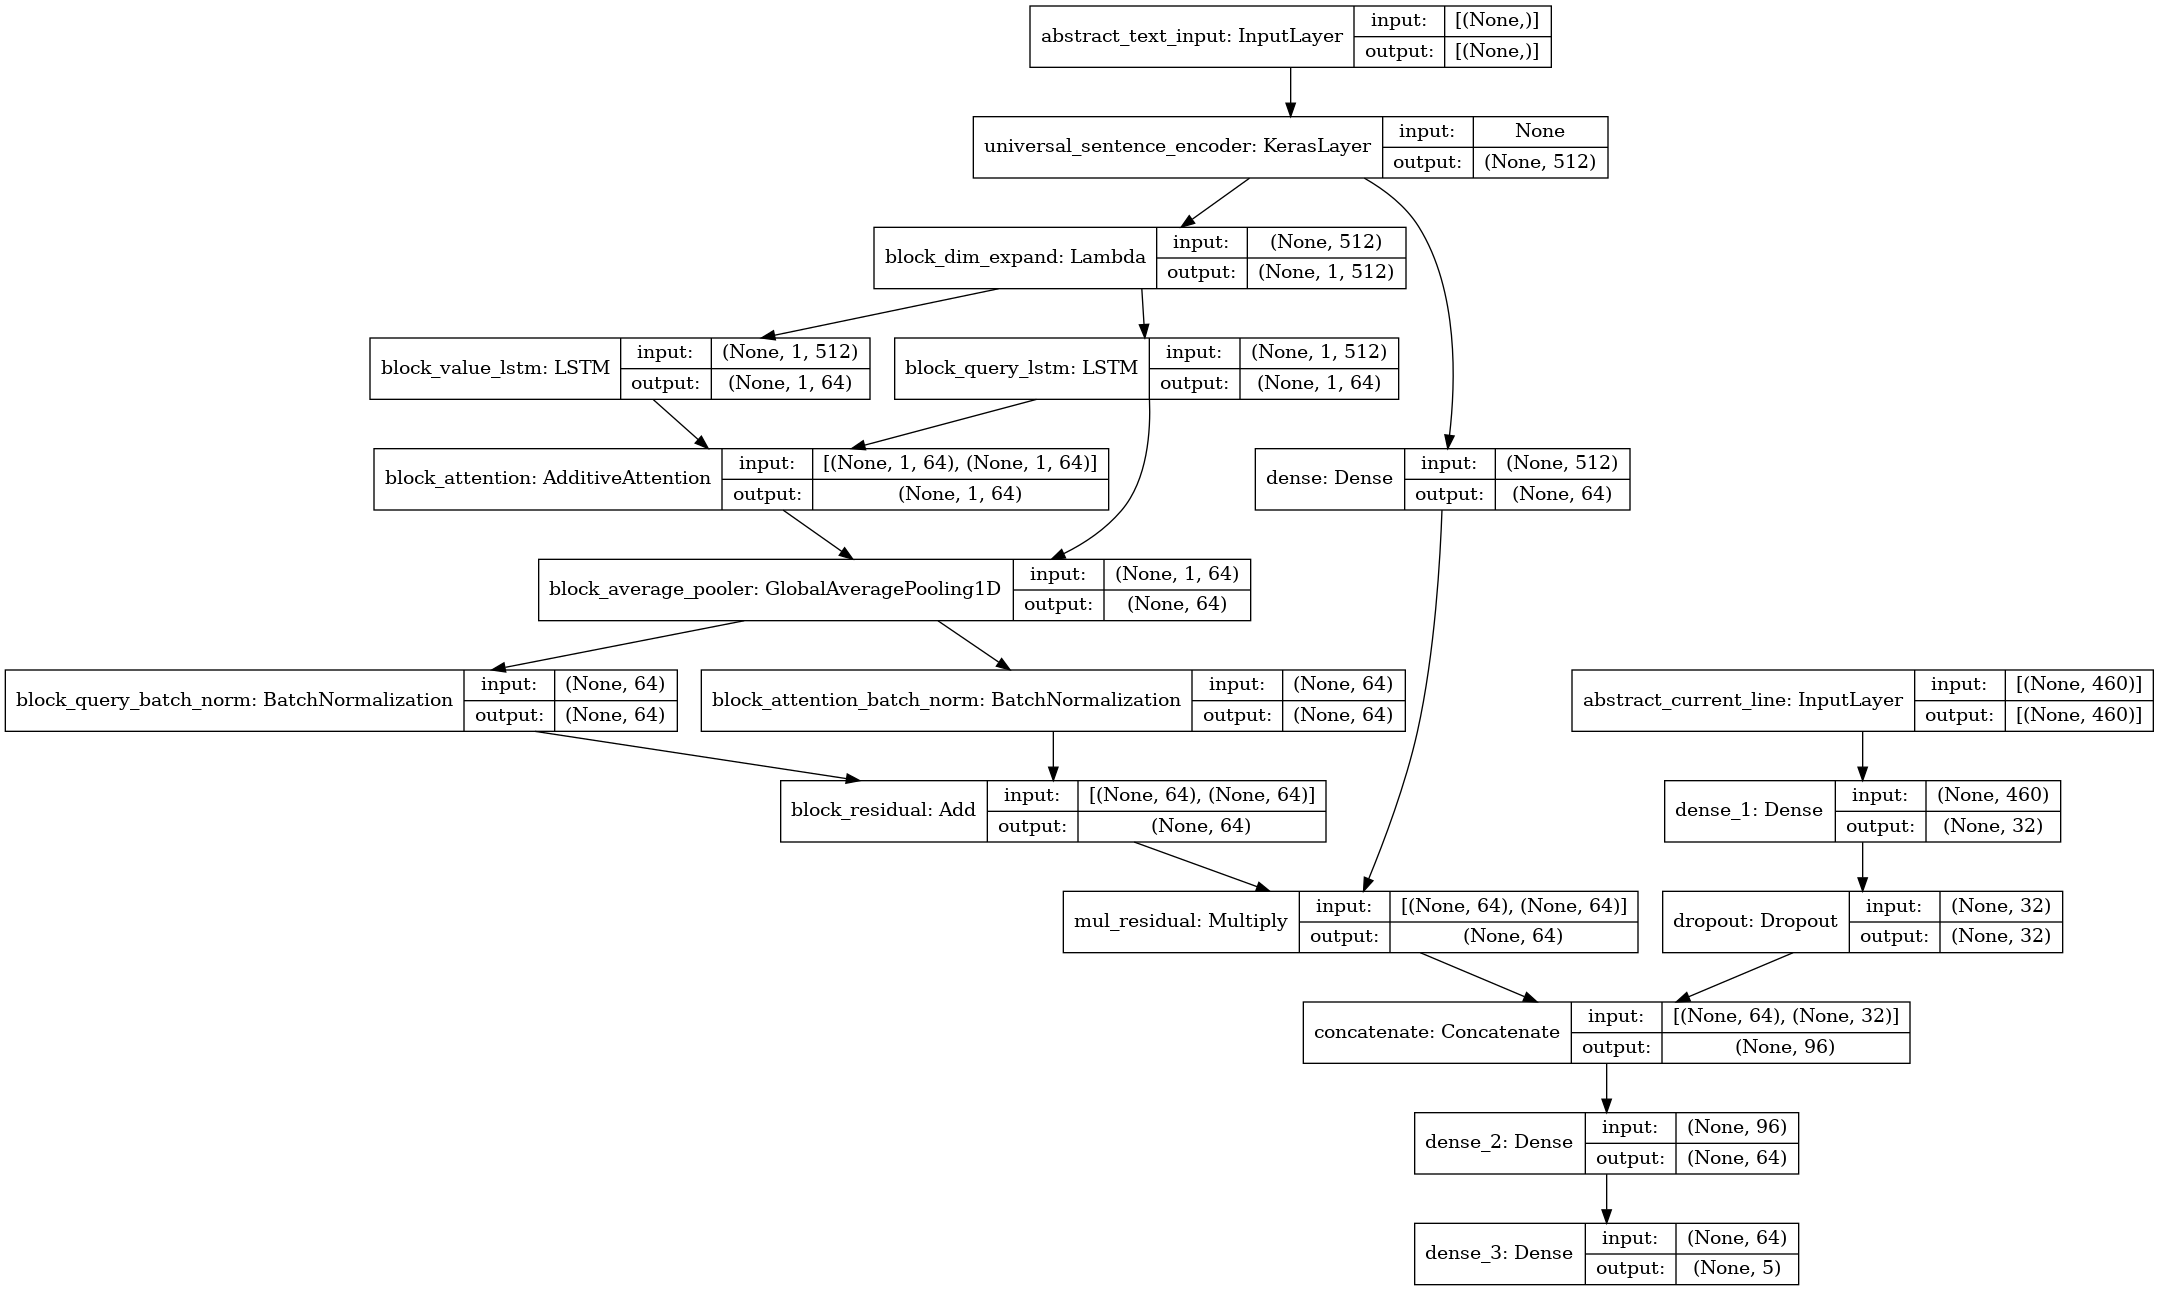

In [47]:
# Explore model visually
plot_model(
    model,
    show_shapes=True,
    expand_nested=True
)

<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#B6EADA;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id=6></a>
# 6 | Train Model
<div style='border-width: 2px;
              border-bottom-width:4px;
              border-bottom-color:#30A2FF;
              border-bottom-style: solid;'></div>
<br>

To train this model we'll use Catagorical Crossentropy as the loss function since this is a classification problem for multiple lables (5 in our case). As for the optimizer, we'll use the Adam optimizer with 0.001 as the (default) learning rate. 

To prevent the occurance of overfitting during training we'll have to make use of TensorFlow's Callback API to implement the EarlyStopping & ReduceLROnPlateau callbacks. The only metrics we'll track during the training of the model will be the loss and accuracy metrics.

### See the following for more information:
- **Categorical Crossentropy Loss Function:**
    - [Understanding Categorical Cross-Entropy Loss, Binary Cross-Entropy Loss, Softmax Loss, Logistic Loss, Focal Loss and all those confusing names](https://gombru.github.io/2018/05/23/cross_entropy_loss/)
    - [TensorFlow Categorical Crossentropy Loss Implementation](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy)
- **Adam Optimizer:** 
    - [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980)
    - [TensorFlow Adam Implementation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
- **TensorFlow Callback API:**
    - [EarlyStopping Implementation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)
    - [ReduceLROnPlateau Implementation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau)
- **TensorFlow Metrics:**
    - [TensorFlow Metrics Overview](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [48]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, 
                tf_valid_data=None, shuffling=False):
    '''
        Trains a TensorFlow model and returns a dict object containing the model metrics history data. 
        
        @params
        - model: (tf.keras.model) -> model to be trained 
        - num_epochs: (int) -> number of epochs to train the model
        - callbacks_list: (list) -> list containing callback fuctions for model
        - tf_train_data: (tf.data.Dataset) -> dataset for model to be train on 
        - tf_valid_data: (tf.data.Dataset) -> dataset for model to be validated on (default=None)
        - shuffling: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        
        @returns
        - model_history: (dict) -> dictionary containing loss and metrics values tracked during training
    '''
    
    model_history = {}
    
    if tf_valid_data != None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
        
    if tf_valid_data == None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

<a id=6.1></a>
### Define Callbacks and Metrics for Model Training

In [49]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=4, 
    restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

EPOCHS = 10
CALLBACKS = [early_stopping_callback, reduce_lr_callback]
METRICS = ['accuracy']

<a id=6.2></a>
### Compile & Train Model

In [50]:
tf.random.set_seed(42)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

print(f'Training {model.name}.')
print(f'Train on {train_sentences_count} samples, validate on {val_sentences_count} samples.')
print('----------------------------------')

model_history = train_model(
    model, EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False
)

Training use_attention_model.
Train on 180040 samples, validate on 30212 samples.
----------------------------------
Epoch 1/10
5627/5627 [==============================] - 100s 16ms/step - loss: 0.6952 - accuracy: 0.8497 - val_loss: 0.6393 - val_accuracy: 0.8750
Epoch 2/10
5627/5627 [==============================] - 92s 16ms/step - loss: 0.6304 - accuracy: 0.8793 - val_loss: 0.6337 - val_accuracy: 0.8771
Epoch 3/10
5627/5627 [==============================] - 89s 16ms/step - loss: 0.6125 - accuracy: 0.8880 - val_loss: 0.6322 - val_accuracy: 0.8777
Epoch 4/10
5627/5627 [==============================] - 87s 15ms/step - loss: 0.5986 - accuracy: 0.8947 - val_loss: 0.6372 - val_accuracy: 0.8751
Epoch 5/10
5627/5627 [==============================] - 88s 16ms/step - loss: 0.5863 - accuracy: 0.9017 - val_loss: 0.6370 - val_accuracy: 0.8740

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/10
5627/5627 [==============================] - 91s 16ms/step 

<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#B6EADA;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id=7></a>
# 7 | Model Performance Inspection
<div style='border-width: 2px;
              border-bottom-width:4px;
              border-bottom-color:#30A2FF;
              border-bottom-style: solid;'></div>
<br>

Now that the model has trained on the data we need to inspect how well it performs on the unseen test data. In order to conduct this inspection we need to evaluate the performance of the model on the test data and record known metrics for classification problems.

In [51]:
# evaluate the model on the test data to see how it performs
model.evaluate(test_ds)

942/942 [==============================] - 9s 10ms/step - loss: 0.6423 - accuracy: 0.8725


[0.642305850982666, 0.8725402355194092]

> It seems like we've achieved similar scores on the test data as seen with the train and validation data. Time to generate predictions and associated probabilities for further inspection

<a id=7.1></a>
### Generate Validation Probabilities & Predictions

In [52]:
# generate validation probabilities
val_probabilities = model.predict(val_ds, verbose=1)
val_probabilities

945/945 [==============================] - 11s 10ms/step


array([[0.8095968 , 0.02130629, 0.01331221, 0.1463208 , 0.00946389],
       [0.76555824, 0.02051999, 0.00566157, 0.19154592, 0.01671431],
       [0.45168516, 0.01588168, 0.03232513, 0.48489007, 0.015218  ],
       ...,
       [0.02191943, 0.02755152, 0.0318241 , 0.02427461, 0.89443034],
       [0.04202563, 0.5146687 , 0.00775454, 0.03439007, 0.40116102],
       [0.00492882, 0.9808637 , 0.00149628, 0.00935122, 0.00335988]],
      dtype=float32)

In [53]:
# generate validation predictions with argmax
val_predictions = tf.argmax(val_probabilities, axis=1)
val_predictions

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

<a id=7.2></a>
### Generate Test Probabilities & Predictions

In [54]:
# generate test probabilities
test_probabilities = model.predict(test_ds, verbose=1)
test_probabilities

942/942 [==============================] - 9s 9ms/step


array([[0.5659339 , 0.02467608, 0.0160143 , 0.37564522, 0.01773047],
       [0.45008188, 0.03344533, 0.10195469, 0.3382459 , 0.07627221],
       [0.02097066, 0.02396155, 0.81897116, 0.0198865 , 0.11621013],
       ...,
       [0.01311004, 0.04804553, 0.00952721, 0.01354049, 0.9157767 ],
       [0.03010055, 0.1413045 , 0.00687282, 0.01895094, 0.8027713 ],
       [0.02195618, 0.9397794 , 0.00129816, 0.014732  , 0.02223429]],
      dtype=float32)

In [55]:
# generate test predictions with argmax
test_predictions = tf.argmax(test_probabilities, axis=1)
test_predictions

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 0, 2, ..., 4, 4, 1])>

<a id=7.3></a>
### Plot Model History

We need to plot the model training performance in order to identify if overfitting or underfitting occured during the model's training.

In [56]:
def plot_training_curves(history):
    
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

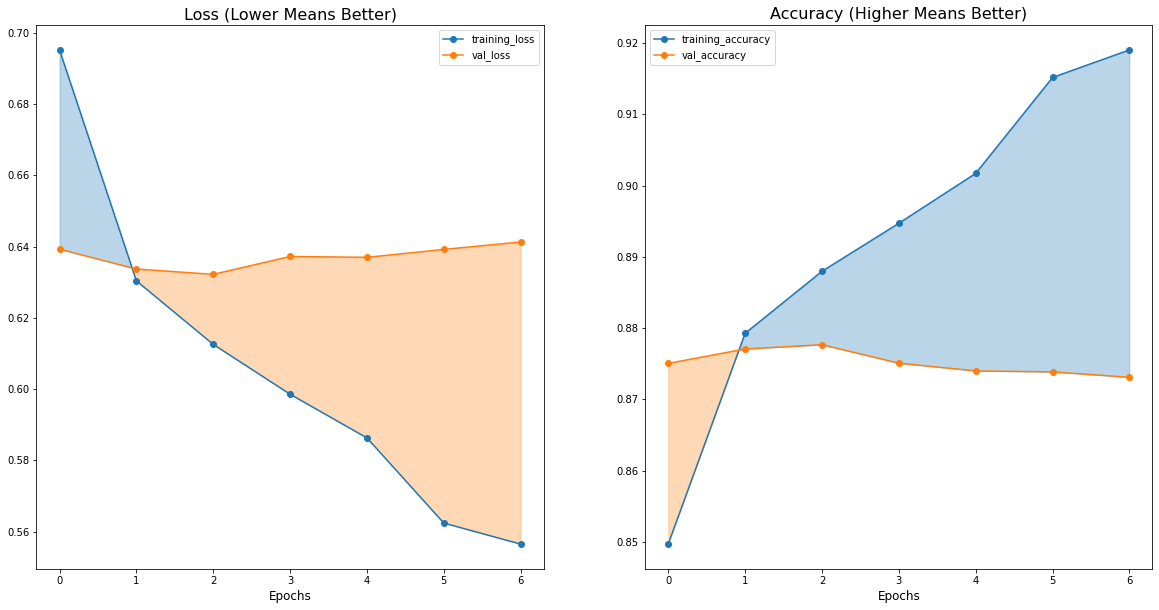

In [57]:
# plot model training history 
plot_training_curves(model_history)

<div class="alert alert-block alert-info">
<h3>Observation</h3>
It seems that the model starts overfitting around the second/third epoch since the train loss curve continues to go lower while the validation loss curve remains somewhat constant. However, since the EarlyStopping callback is implemented the model's best weights are saved after the model's training is stopped.
</div>

<a id=7.4></a>
### Inspect Model Performance Via Classification Metrics

Since this is a classification problem we'll make use of some well known classification metrics. Hence, we'll make use of the Scikit Learn library to inspect the model. We'll also use the following to inspect the model:

- [Classification Report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report)
- [Accuracy Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) 
- [Top k Accuracy Score (top 3 in this case)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.top_k_accuracy_score.html#sklearn.metrics.top_k_accuracy_score)
- [F1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) 
- [Precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)
- [Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)
- [Matthews Correlation Coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)


In [58]:
# Generate validation classification report
print(classification_report(val_labels_encoded, val_predictions, target_names=class_names))

              precision    recall  f1-score   support

  BACKGROUND       0.70      0.86      0.77      3449
 CONCLUSIONS       0.90      0.93      0.92      4582
     METHODS       0.93      0.91      0.92      9964
   OBJECTIVE       0.76      0.52      0.62      2376
     RESULTS       0.91      0.91      0.91      9841

    accuracy                           0.88     30212
   macro avg       0.84      0.83      0.83     30212
weighted avg       0.88      0.88      0.88     30212



In [59]:
# Generate test classification report
print(classification_report(test_labels_encoded, test_predictions, target_names=class_names))

              precision    recall  f1-score   support

  BACKGROUND       0.71      0.86      0.78      3621
 CONCLUSIONS       0.90      0.93      0.92      4571
     METHODS       0.92      0.91      0.91      9897
   OBJECTIVE       0.75      0.52      0.61      2333
     RESULTS       0.91      0.90      0.90      9713

    accuracy                           0.87     30135
   macro avg       0.84      0.82      0.82     30135
weighted avg       0.87      0.87      0.87     30135



<div class="alert alert-block alert-info">
<h3>Observation</h3>
By looking at the model's f1-score, we obeserve that the model has a good understanding of what abstract lines should be classified as <code>Conclusions</code>, <code>Methods</code> and <code>Results</code>. However, the model struggles to understand which lines should be classified as <code>Background</code> or <code>Objective</code>. The reason for this could be due to the lower number of samples for these two classes in relation to the other classes.
<br><br>
Another reason could be that the embeddings for the abstact texts from the two classes are similar since:
<ol type = "1">
<li>The encoder generates similar embeddings (good reason to try another encoder/tranformer).</li>
<li>The texts are misclasiffied (identified classes were swapped during the creation of the dataset).</li>
<li>There are noise within the texts, causing the model to misclassify these texts (potentially due to bais).</li>
</ol>

Possible solutions to these problems are:
<ol type = "1">
<li>Gather more samples for these classes so that the dataset is balances (all classes have about the same number of samples in the dataset).</li>
<li>Use another encoder/tranformer (e.g. DeBERTa-v3-xsmall).</li>
<li>Check probabilties for all predictions to identify misclassiffied prediction (good model required).</li>
<li>Apply text-preprocessing methods such as removing special characters/links/stopwords, converting texts to lowercase, ect.</li>
</ol>
</div>

<a id=7.5></a>
### Inspect Validation Performance

In [60]:
def generate_preformance_scores(y_true, y_pred, y_probabilities):
    
    model_accuracy = round(accuracy_score(y_true, y_pred), 5)
    top_3_accuracy = round(top_k_accuracy_score(y_true, y_probabilities, k=3), 5)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(test_labels_encoded, 
                                                                                 test_predictions, 
                                                                                 average="weighted")
    model_precision, model_recall, model_f1 = round(model_precision, 5), round(model_recall, 5), round(model_f1, 5)
    model_matthews_corrcoef = round(matthews_corrcoef(y_true, y_pred), 5)
    
    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy}\n')
    print('_____________________________________________')
    print(f'top_3_accuracy_score:\t{top_3_accuracy}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef}\n')
    print('=============================================')
    
    return

In [61]:
generate_preformance_scores(val_labels_encoded, val_predictions, val_probabilities)


Performance Metrics:

accuracy_score:		0.87766

_____________________________________________
top_3_accuracy_score:	0.99487

_____________________________________________
precision_score:	0.87395

_____________________________________________
recall_score:		0.87254

_____________________________________________
f1_score:		0.87068

_____________________________________________
matthews_corrcoef:	0.83615



<a id=7.6></a>
### Inspect Test Performance

In [62]:
generate_preformance_scores(test_labels_encoded, test_predictions, test_probabilities)


Performance Metrics:

accuracy_score:		0.87254

_____________________________________________
top_3_accuracy_score:	0.99396

_____________________________________________
precision_score:	0.87395

_____________________________________________
recall_score:		0.87254

_____________________________________________
f1_score:		0.87068

_____________________________________________
matthews_corrcoef:	0.8296



<div class="alert alert-block alert-info">
<h3>Observation</h3>
The model scores a nearly perfect top-3 accuracies score on the test data, which means the model almost always has the correct label as a second or third best prediction. 

Also, the model achieves a high score for the matthews correlation coefficient which implies that the model predictions are nearly prefect (high quality).
</div>

<a id=7.7></a>
### Plot Confusion Matrix
In order to visually inspect correctly and misclassified predictions made by the model we need to plot a confusion matrix with the predicted targets. 

In [63]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=11): 
    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size},
        fmt='d',
        linewidths=1, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    
    # Plot confusion matrix
    plt.show()
    
    return

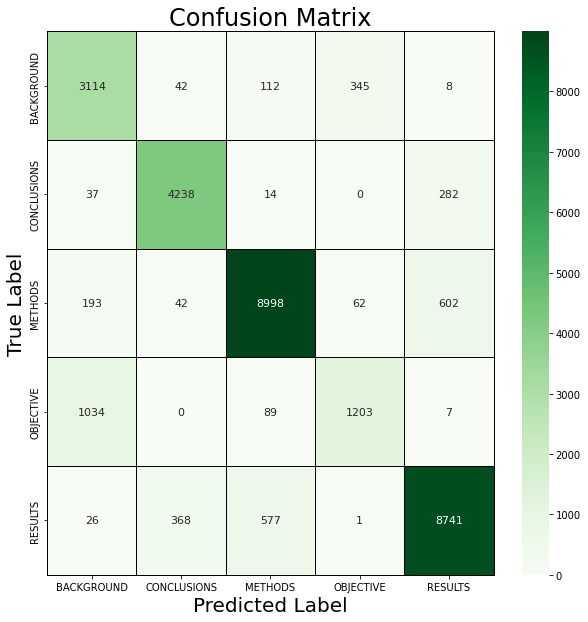

In [64]:
# View Confusion Matrix
plot_confusion_matrix(
    test_labels_encoded, 
    test_predictions, 
    figsize=(10, 10), 
    classes=list(class_names))

<div class="alert alert-block alert-info">
<h3>Observation</h3>
We see that the model is confuses samples from the <code>Background</code> and <code>Objective</code> classes. 
The same behavior occurs with the <code>Methods</code> and <code>Results</code> classes. This could be due to the reasons outlined above in the classification metrics inspection section.
</div>

<a id=7.8></a>
### Inspect Predicted Test Labels

To gain a better understanding of the model's performance we need to invert the prediction we inspect, meaning we need to look at the **least correct** and **most incorrect** predictions.

We do this to see where the model struggles most when having to make a prediction. 

In [65]:
test_df

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,24845963,24845963_0_9,This study analyzed liver function abnormaliti...,0,9,0_9,BACKGROUND
1,24845963,24845963_1_9,A post hoc analysis was conducted with the use...,1,9,1_9,RESULTS
2,24845963,24845963_2_9,Liver function tests ( LFTs ) were measured at...,2,9,2_9,RESULTS
3,24845963,24845963_3_9,Survival analyses were used to assess the asso...,3,9,3_9,RESULTS
4,24845963,24845963_4_9,The percentage of patients with abnormal LFTs ...,4,9,4_9,RESULTS
...,...,...,...,...,...,...,...
30130,24261927,24261927_13_18,There was a statistically significant between-...,13,18,13_18,RESULTS
30131,24261927,24261927_14_18,There were no statistically significant betwee...,14,18,14_18,RESULTS
30132,24261927,24261927_15_18,There was no significant association between s...,15,18,15_18,RESULTS
30133,24261927,24261927_16_18,No adverse effects were reported .,16,18,16_18,RESULTS


In [66]:
# Get top 3 predictions
top_3_values, top_3_indices = tf.nn.top_k(test_probabilities, k=3)

In [67]:
%%time
# copy test_df
test_pred_df = test_df.copy()

# add best predictions
test_pred_df['prediction'] = [class_names[_] for _ in top_3_indices[:, 0]]
test_pred_df['probability'] = list(top_3_values[:, 0].numpy())

# add 2nd best predictions
test_pred_df['prediction_2'] = [class_names[_] for _ in top_3_indices[:, 1]]
test_pred_df['probability_2'] = list(top_3_values[:, 1].numpy())

# add 3rd best predictions
test_pred_df['prediction_3'] = [class_names[_] for _ in top_3_indices[:, 2]]
test_pred_df['probability_3'] = list(top_3_values[:, 2].numpy())

CPU times: user 14.7 s, sys: 0 ns, total: 14.7 s
Wall time: 14.7 s


In [68]:
test_pred_df

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target,prediction,probability,prediction_2,probability_2,prediction_3,probability_3
0,24845963,24845963_0_9,This study analyzed liver function abnormaliti...,0,9,0_9,BACKGROUND,BACKGROUND,0.565934,OBJECTIVE,0.375645,CONCLUSIONS,0.024676
1,24845963,24845963_1_9,A post hoc analysis was conducted with the use...,1,9,1_9,RESULTS,BACKGROUND,0.450082,OBJECTIVE,0.338246,METHODS,0.101955
2,24845963,24845963_2_9,Liver function tests ( LFTs ) were measured at...,2,9,2_9,RESULTS,METHODS,0.818971,RESULTS,0.116210,CONCLUSIONS,0.023962
3,24845963,24845963_3_9,Survival analyses were used to assess the asso...,3,9,3_9,RESULTS,RESULTS,0.621580,METHODS,0.294020,OBJECTIVE,0.031124
4,24845963,24845963_4_9,The percentage of patients with abnormal LFTs ...,4,9,4_9,RESULTS,RESULTS,0.737867,METHODS,0.180719,BACKGROUND,0.030561
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30130,24261927,24261927_13_18,There was a statistically significant between-...,13,18,13_18,RESULTS,RESULTS,0.905574,OBJECTIVE,0.030088,BACKGROUND,0.024457
30131,24261927,24261927_14_18,There were no statistically significant betwee...,14,18,14_18,RESULTS,RESULTS,0.929826,CONCLUSIONS,0.039420,OBJECTIVE,0.014796
30132,24261927,24261927_15_18,There was no significant association between s...,15,18,15_18,RESULTS,RESULTS,0.915777,CONCLUSIONS,0.048046,OBJECTIVE,0.013540
30133,24261927,24261927_16_18,No adverse effects were reported .,16,18,16_18,RESULTS,RESULTS,0.802771,CONCLUSIONS,0.141304,BACKGROUND,0.030101


In [69]:
def view_prediction(pred_df, sample_index):
    sample = pred_df.iloc[sample_index]
    
    print('====================================================')
    print(f'id:\t\t{sample.abstract_id}')
    print('____________________________________________________')
    print(f'text:\n\n{sample.abstract_text}')
    print('____________________________________________________')
    print(f'current_line:\t{sample.current_line}')
    print('____________________________________________________')
    print(f'target:\t\t{sample.target}')
    print('____________________________________________________')
    print(f'predictions:\n')
    print(f'1: {sample.prediction}({sample.probability})')
    print(f'2: {sample["prediction_2"]}({sample["probability_2"]})')
    print(f'3: {sample["prediction_3"]}({sample["probability_3"]})')
    print('====================================================')
    
    return

<a id=7.9></a>
### Inspect Least Accurate Predictions

In [70]:
least_accurate = test_pred_df.loc[test_pred_df.target == test_pred_df.prediction].sort_values('probability', inplace=False)

In [71]:
least_accurate.head(5).T

,19029,469,16599,7683,16588
abstract_id,24492904,25564105,24811543,24283778,24811543
line_id,24492904_4_9,25564105_6_14,24811543_23_28,24283778_2_4,24811543_12_28
abstract_text,CBT was effective in reducing PTSD and depress...,Although the study was stopped early due to lo...,The skill retention was present when either th...,Analysis of a recent study evaluating the effi...,Mean trunk flexion angle and velocity signific...
line_number,4,6,23,2,12
total_lines,9,14,28,4,28
current_line,4_9,6_14,23_28,2_4,12_28
target,RESULTS,RESULTS,RESULTS,METHODS,RESULTS
prediction,RESULTS,RESULTS,RESULTS,METHODS,RESULTS
probability,0.258096,0.288501,0.29233,0.29308,0.300398
prediction_2,BACKGROUND,BACKGROUND,CONCLUSIONS,CONCLUSIONS,OBJECTIVE


In [72]:
view_prediction(least_accurate, 0)

id:		24492904
____________________________________________________
text:

CBT was effective in reducing PTSD and depressive symptoms and improved psychological resilience .
____________________________________________________
current_line:	4_9
____________________________________________________
target:		RESULTS
____________________________________________________
predictions:

1: RESULTS(0.2580958306789398)
2: BACKGROUND(0.23810528218746185)
3: CONCLUSIONS(0.20500904321670532)


In [73]:
view_prediction(least_accurate, 1)

id:		25564105
____________________________________________________
text:

Although the study was stopped early due to lower than expected occurrence of the primary end points , sufficient data were available to assess the impact of the interventions on drug use and injection-related risk behavior .
____________________________________________________
current_line:	6_14
____________________________________________________
target:		RESULTS
____________________________________________________
predictions:

1: RESULTS(0.28850072622299194)
2: BACKGROUND(0.2848803997039795)
3: METHODS(0.20476877689361572)


<a id=7.10></a>
### Inspect Most Inaccurate Predictions

In [74]:
most_inaccurate = test_pred_df.loc[test_pred_df.target != test_pred_df.prediction].sort_values('probability', inplace=False)

In [75]:
most_inaccurate.head(5).T

,16584,16585,21290,18722,4894
abstract_id,24811543,24811543,24360934,25587059,25016974
line_id,24811543_8_28,24811543_9_28,24360934_3_8,25587059_10_16,25016974_2_10
abstract_text,Training effectiveness was assessed using a pe...,The key outcome variables were peak trunk flex...,"After iTBSiM1 , improvements in paretic grip-l...",non-diffuse-trickling '' and 228.00 66.24 m in...,The purpose of the present study was to follow...
line_number,8,9,3,10,2
total_lines,28,28,8,16,10
current_line,8_28,9_28,3_8,10_16,2_10
target,METHODS,METHODS,RESULTS,RESULTS,OBJECTIVE
prediction,OBJECTIVE,BACKGROUND,BACKGROUND,BACKGROUND,BACKGROUND
probability,0.265044,0.27445,0.287151,0.293537,0.294078
prediction_2,METHODS,METHODS,METHODS,METHODS,METHODS


In [76]:
view_prediction(most_inaccurate, 0)

id:		24811543
____________________________________________________
text:

Training effectiveness was assessed using a perturbation test in an immersive virtual environment .
____________________________________________________
current_line:	8_28
____________________________________________________
target:		METHODS
____________________________________________________
predictions:

1: OBJECTIVE(0.26504427194595337)
2: METHODS(0.24237996339797974)
3: BACKGROUND(0.24141600728034973)


<div class="alert alert-block alert-info">
<h3>Observation</h3>
The model seems to struggle with making predictions on edge cases. This could be due to bias in the model or the nature of the dataset (not enough samples or imbalanced classes). To handle this problem it would be best to train on more samples, experiment with other encoders/transformers or maybe train the model using cross-validation techniques.
</div>

<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#B6EADA;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id=8></a>
# 8 | Predict On Sample From The Wild
<div style='border-width: 2px;
              border-bottom-width:4px;
              border-bottom-color:#30A2FF;
              border-bottom-style: solid;'></div>
<br>

Let's predict on a random abstract taken from a public medical research paper available on PubMed to see what the model predicts.

> Abstract taken from here: [Discovery and systematic characterization of risk variants and genes for coronary artery disease in over a million participants](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9729111/)

In [77]:
wild_abstract_text = """The discovery of genetic loci associated with complex diseases has outpaced the elucidation of 
mechanisms of disease pathogenesis. Here we conducted a genome-wide association study (GWAS) 
for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of 
predominantly European ancestry. We detected 241 associations, including 30 new loci. Cross-
ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci. We prioritized likely 
causal variants using functionally informed fine-mapping, yielding 42 associations with less than 
five variants in the 95% credible set. Similarity-based clustering suggested roles for early 
developmental processes, cell cycle signaling and vascular cell migration and proliferation in the 
pathogenesis of CAD. We prioritized 220 candidate causal genes, combining eight complementary 
approaches, including 123 supported by three or more approaches. Using CRISPR–Cas9, we 
experimentally validated the effect of an enhancer in MYO9B, which appears to mediate CAD risk by 
regulating vascular cell motility. Our analysis identifies and systematically characterizes >250 risk 
loci for CAD to inform experimental interrogation of putative causal mechanisms for CAD."""

In [78]:
# view the abstract
print(wild_abstract_text)

The discovery of genetic loci associated with complex diseases has outpaced the elucidation of 
mechanisms of disease pathogenesis. Here we conducted a genome-wide association study (GWAS) 
for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of 
predominantly European ancestry. We detected 241 associations, including 30 new loci. Cross-
ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci. We prioritized likely 
causal variants using functionally informed fine-mapping, yielding 42 associations with less than 
five variants in the 95% credible set. Similarity-based clustering suggested roles for early 
developmental processes, cell cycle signaling and vascular cell migration and proliferation in the 
pathogenesis of CAD. We prioritized 220 candidate causal genes, combining eight complementary 
approaches, including 123 supported by three or more approaches. Using CRISPR–Cas9, we 
experimentally validated the effect of an enhancer

In [79]:
wild_abstract_preprocessed = """The discovery of genetic loci associated with complex diseases has outpaced the elucidation of mechanisms of disease pathogenesis .
Here we conducted a genome-wide association study (GWAS) for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of predominantly European ancestry .
We detected 241 associations, including 30 new loci . 
Cross-ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci .
We prioritized likely causal variants using functionally informed fine-mapping, yielding 42 associations with less than five variants in the 95% credible set .
Similarity-based clustering suggested roles for early developmental processes, cell cycle signaling and vascular cell migration and proliferation in the pathogenesis of CAD .
We prioritized 220 candidate causal genes, combining eight complementary approaches, including 123 supported by three or more approaches .
Using CRISPR–Cas9, we experimentally validated the effect of an enhancer in MYO9B, which appears to mediate CAD risk by regulating vascular cell motility .
Our analysis identifies and systematically characterizes >250 risk loci for CAD to inform experimental interrogation of putative causal mechanisms for CAD ."""

<a id=8.1></a>
### Preprocess the Wild Abstract
We need to preprocess the wild abstract text so that it is 'consumable' by the model. 

In [80]:
# Split the abstract into it's lines as seen in the original paper
wild_texts = [_  for _ in wild_abstract_preprocessed.split('\n')]

# convert the list of texts line into a numpy array
wild_texts = np.array(wild_texts).reshape((len(wild_texts), 1))
wild_texts.shape

(9, 1)

In [81]:
wild_texts

array([['The discovery of genetic loci associated with complex diseases has outpaced the elucidation of mechanisms of disease pathogenesis .'],
       ['Here we conducted a genome-wide association study (GWAS) for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of predominantly European ancestry .'],
       ['We detected 241 associations, including 30 new loci . '],
       ['Cross-ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci .'],
       ['We prioritized likely causal variants using functionally informed fine-mapping, yielding 42 associations with less than five variants in the 95% credible set .'],
       ['Similarity-based clustering suggested roles for early developmental processes, cell cycle signaling and vascular cell migration and proliferation in the pathogenesis of CAD .'],
       ['We prioritized 220 candidate causal genes, combining eight complementary approaches, including 123 supported by three or more approa

In [82]:
# generate the combined feature current_line for the wild abstract
wild_current_lines = [f'{_}_{len(wild_texts)}' for _ in range(len(wild_texts))]
print(wild_current_lines)

['0_9', '1_9', '2_9', '3_9', '4_9', '5_9', '6_9', '7_9', '8_9']


In [83]:
# one-hot encode the current_lines feature
wild_current_lines_transformed = line_one_hot_encoder.transform(np.array(wild_current_lines).reshape(-1, 1))
wild_current_lines_transformed.shape

(9, 460)

<a id=8.2></a>
### Generate Probabilities

In [84]:
wild_probabilities = model.predict((wild_texts, (wild_current_lines_transformed)), verbose=1)
wild_probabilities

1/1 [==============================] - 1s 1s/step


array([[0.8811376 , 0.01074718, 0.00431305, 0.09733442, 0.00646779],
       [0.20343174, 0.04167665, 0.538441  , 0.15976527, 0.05668532],
       [0.04829067, 0.03201596, 0.5887517 , 0.0414773 , 0.28946435],
       [0.04820221, 0.03215114, 0.6120435 , 0.03000102, 0.27760214],
       [0.02688909, 0.01737305, 0.28053236, 0.03480392, 0.64040154],
       [0.03057941, 0.044233  , 0.47828293, 0.03192466, 0.41498002],
       [0.03227982, 0.09371537, 0.1782001 , 0.03000739, 0.6657973 ],
       [0.01346965, 0.9013139 , 0.02555705, 0.01671829, 0.04294107],
       [0.00432777, 0.93108475, 0.01479184, 0.01710935, 0.03268633]],
      dtype=float32)

<a id=8.3></a>
### View Wild Abstract Predictions

In [85]:
def view_wild_prediction(texts, current_lines, probabilities):
    for text, current_line, prob in zip(texts, current_lines, probabilities):
        top_3_probs, top_3_labels = tf.nn.top_k(prob, k=3)
        predicted_labels = [class_names[_] for _ in top_3_labels]
        print(f'Text:\n\n{text[0]}\n')
        print(f'Predictions:\n')
        print(f'1: {predicted_labels[0]}({top_3_probs[0]:.6f})')
        print(f'2: {predicted_labels[1]}({top_3_probs[1]:.6f})')
        print(f'3: {predicted_labels[2]}({top_3_probs[2]:.6f})')
        print('====================================================')
    
    return

In [86]:
view_wild_prediction(wild_texts, wild_current_lines, wild_probabilities)

Text:

The discovery of genetic loci associated with complex diseases has outpaced the elucidation of mechanisms of disease pathogenesis .

Predictions:

1: BACKGROUND(0.881138)
2: OBJECTIVE(0.097334)
3: CONCLUSIONS(0.010747)
Text:

Here we conducted a genome-wide association study (GWAS) for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of predominantly European ancestry .

Predictions:

1: METHODS(0.538441)
2: BACKGROUND(0.203432)
3: OBJECTIVE(0.159765)
Text:

We detected 241 associations, including 30 new loci . 

Predictions:

1: METHODS(0.588752)
2: RESULTS(0.289464)
3: BACKGROUND(0.048291)
Text:

Cross-ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci .

Predictions:

1: METHODS(0.612043)
2: RESULTS(0.277602)
3: BACKGROUND(0.048202)
Text:

We prioritized likely causal variants using functionally informed fine-mapping, yielding 42 associations with less than five variants in the 95% credible set .

Predictions:

1: RES

<a id=8.4></a>
### View the segmented abstract in color

In [87]:
def display_segemented_abstract(abstract_texts, labels, color=False):
    colors = {
        'BACKGROUND': 34,     # blue
        'OBJECTIVE': 35,      # magenta
        'METHODS': 32,        # green
        'RESULTS': 33,        # yellow
        'CONCLUSIONS': 31     # red
    }
    
    segmented_abstract = ""
    
    for text_line, text_label in zip(abstract_texts, labels):
        if color:
            segmented_abstract += '\033[1;{}m{:<12s}\n{:<12s}\n\n'.format(colors[text_label], text_label, text_line[0])
        else:
            segmented_abstract += '{:<12s}\n {:<12s}\n'.format(text_label, text_line[0])
            
    return segmented_abstract

In [88]:
wild_predictions = np.argmax(wild_probabilities, axis=1)
wild_labels = [class_names[_] for _ in wild_predictions]

In [89]:
wild_segmented_abstract = display_segemented_abstract(wild_texts, wild_labels, color=True)
print(wild_segmented_abstract)

BACKGROUND  
The discovery of genetic loci associated with complex diseases has outpaced the elucidation of mechanisms of disease pathogenesis .

METHODS     
Here we conducted a genome-wide association study (GWAS) for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of predominantly European ancestry .

METHODS     
We detected 241 associations, including 30 new loci . 

METHODS     
Cross-ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci .

RESULTS     
We prioritized likely causal variants using functionally informed fine-mapping, yielding 42 associations with less than five variants in the 95% credible set .

METHODS     
Similarity-based clustering suggested roles for early developmental processes, cell cycle signaling and vascular cell migration and proliferation in the pathogenesis of CAD .

RESULTS     
We prioritized 220 candidate causal genes, combining eight complementary approaches, including 123 supported by thre

<div class="alert alert-block alert-info">
<h3>Observation</h3>
We can observe that the model is confident in all of the predictions. We also observe a logical flow among the segmented sentences. 
</div>

> It should be noted that since label smoothing was applied to the `current_lines` feature, the above prediction are seemingly better when evaluating the wild abstract without label smoothing. The observation above still holds true when evaluating with label smoothing.

<br>
<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#B6EADA;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>
           
<a id=9></a>
# 9 | Discussion Regarding Model Performance
<div style='border-width: 2px;
              border-bottom-width:4px;
              border-bottom-color:#30A2FF;
              border-bottom-style: solid;'></div>
<br>

After training the model and conducting a performance inspection, we observe a decent Matthews Correlation Coefficient (~0.83) on the test set, which implies that the model's predictions are statistically of high quality for all labels and that the model does indeed generalise to unseen samples.

However, we also observe that the model's F1-score (~87) falls slightly under the F1-score for the model described in the paper ([Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/abs/1612.05251)) which inspired this notebook (which is 89.9 as seen in Table 2).

One can argue that this is due to the model's inability to learn the difference between the texts labelled `BACKGROUND` and `OBJECTIVE` as both labels have substantially fewer samples than the other classes (i.e. `METHODS`). Note that we can observe this shortcoming when we conduct an inverted inspection (inspecting the least accurate and most inaccurate predictions) on the model's performance.

Overcoming this imbalance might not be convenient when considering upsampling techniques such as SMOTE and gathering more samples since this imbalance seems to be the case of a natural pattern in the data. This is due to backgrounds and objectives requiring fewer sentences for discussion in an abstract in relation to other sections, such as methods. 

The best way to handle this model's shortcomings is to use a language model capable of producing better text embeddings while achieving a similar compute efficiency as the Universal Sentence Encoder (USE). One great replacement for the USE would be DeBERTa-v3-xsmall as it is a transformer which definetly outperforms the USE. 

However, note that its compute efficiency will be an obstacle as DeBERTa-v3 with TensorFlow is much slower since it is natively implemented in PyTorch, which provides better compute efficiency. Therefore, the usage of USE with DeBERTa-v3-xsmall was not explored due to the constraints outlined for this notebook.

<div style='border-width: 2px;
              border-bottom-width:4px;
              border-bottom-color:#30A2FF;
              border-bottom-style: solid;'></div>

<a id=conclusion></a>
# <center>Conclusion</center>
<div style='border-width: 2px;
              border-bottom-width:4px;
              border-bottom-color:#30A2FF;
              border-bottom-style: solid;'></div>
<br>

In this notebook, we managed to implement a Natural Language Processing (NLP) model capable of segmenting text lines in abstracts from medical research papers. We found that the model was capable of learning the task of the said segmentation with minimal dependencies as few features were used to train the model. The model was also capable of generalising to unseen data according to the performance metrics used, notably achieving a decent **F1-score** & **Matthews correlation coefficient** on the training, validation and testing data.

Although this model does not outperform the model introduced in the paper ([Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/abs/1612.05251)), there is still room for improvement and we can consider this notebook's model as a baseline in pursuit of building an improved model. 

### Options to consider for future improvements:
As for future improvement, we should consider doing the following:

- **Replacing the Universal Sentence Encoder (USE) with DeBERTa-v3-xsmall**

    DeBERTa-v3-xsmall is the better option in comparison to USE as it achieves better performance. However, the inference time achieved by the TensorFlow version is the reason why its usage was not explored in this notebook. It seems that the TensorFlow version from HuggingFace🤗 is not optimized as the original version of DeBERTa is implemented in PyTorch. With the usage of a GPU, training a model with DeBERTa-v3-xsmall as the backbone implemented in TensorFlow takes about ~1h30m to complete a single epoch.

- **Preprocessing Texts**

    In this notebook text preprocessing was not implemented, and the raw text data was given to the model to train on. This was done to reduce the number of feature dependencies required to train the model (the same was done with the `current_line` feature). Some preprocessing techniques that may be useful to implement include:
    - removing stopwords
    - removing punctuation, special characters and webpage links
    - converting texts to lowercase
    - using stemming and lemmatization

For more information check out this blog post: [NLP: Building Text Cleanup and PreProcessing Pipeline](https://towardsdatascience.com/nlp-building-text-cleanup-and-preprocessing-pipeline-eba4095245a0)

A special shoutout to [Daniel Bourke's](https://www.youtube.com/@mrdbourke/featured) Zero to Mastery course on Deep Learning with TensorFlow as this is where I first encountered this classification task. I am not affiliated with Zero to Mastery, however, I want to acknowledge where I first encountered this task. Check out the GitHub page here: [Zero to Mastery Deep Learning with TensorFlow](https://github.com/mrdbourke/tensorflow-deep-learning).

<div class="alert alert-block" style='color:#000000;
           padding: 10px 10px 10px 10px;
           border-radius:10px;
           background-color:#00E4FF;
           font-size:100%;'>  
    <center><h2><b>To you, the notebook visitor...</b></h2>
    <b>It takes a lot of effort and time from me to create my notebooks. 
    <br>
    So, if you <u>FORK or found this notebook HELPFUL</u>, please <u>consider</u> supporting me with an upvote! 
    <br>
    I truly appreciate your time and attention!</b>
<h3>Once again, thank you for visiting my notebook!🙏</h3></center>
</div>